# Model comparison

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
class Sim_M0(swyft.Simulator):
    def __init__(self):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        
    def build(self, graph):
        x = graph.node('x', lambda: np.random.randn(10))
        
sim = Sim_M0()

In [4]:
class Sim_M1(swyft.Simulator):
    def __init__(self):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        
    def build(self, graph):
        x = graph.node('x', lambda: np.random.randn(10)*1.1)

In [5]:
class Simulator(swyft.Simulator):
    def __init__(self):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        
    def build(self, graph):
        d = graph.node('d', lambda: np.random.choice(2, size=1).astype(float))
        with graph.prefix("M0/"):
            Sim_M0().build(graph)
        with graph.prefix("M1/"):
            Sim_M1().build(graph)
        x = graph.switch('x', [graph["M0/x"], graph["M1/x"]], d)
        
sim = Simulator()

In [6]:
samples = sim.sample(10000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 58423.49it/s]


In [7]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 10, num_params = 1, varnames = 'd')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['d'])
        return logratios

In [8]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [9]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.02, 0.1], num_workers = 0, batch_size = 256)

In [10]:
network = Network()

In [11]:
trainer.fit(network, dm)


  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 18.0 K
-----------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.144     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training ba

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Inference

In [12]:
prior_samples = sim.sample(2_000, targets = ['d'])
test_samples = sim.sample(2_000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 50567.60it/s]


In [13]:
test_results = trainer.test_coverage(network, test_samples, prior_samples)

Predicting: 34it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 34it [00:00, ?it/s]

In [14]:
def select(cs, mask_fn):
    mask = mask_fn(cs.params)
    return swyft.CoverageSamples(cs.prob_masses[mask], cs.params[mask], cs.parnames)

test_results_masked = select(test_results, lambda params: params[:,0,0] == 1)
#(cs.params[..., 0] > 0).shape

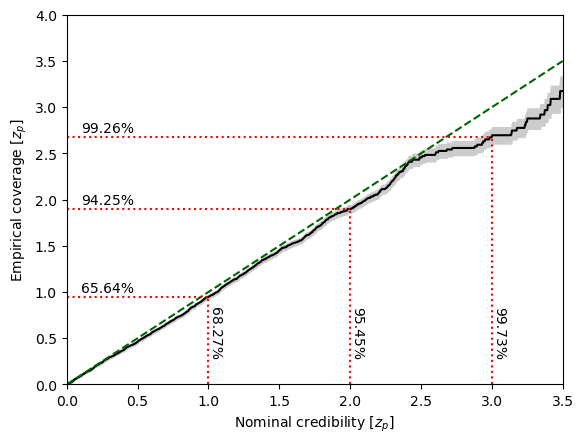

In [16]:
swyft.plot_zz(test_results, 'd[0]', ax = plt.gca(), bins = 1000)